In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [12]:
# Load the dataset
df = pd.read_csv('C:/Users/a0095989/Desktop/important/Thesis/Model_Thesis/imputed_deu_data1.csv')

# Display the first few rows of the dataset
#print(df.head())

# Check for missing values
#print(df.isnull().sum())

# Basic statistics
#print(df.describe())

In [13]:
# Convert Year and Month into a single datetime feature
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str))

# Sort data by City and Date
df = df.sort_values(by=['City', 'Date'])

# Drop unnecessary columns (if any)
df = df.drop(columns=['Date'])  # Drop if not needed

# Check the preprocessed data
print(df.head())

           dt  AverageTemperature  AverageTemperatureUncertainty    City  \
0  1744-01-01              -0.673                          2.095  Aachen   
1  1744-02-01               0.762                          1.923  Aachen   
2  1744-03-01               3.754                          1.626  Aachen   
3  1744-04-01               8.599                          2.485  Aachen   
4  1744-05-01              11.699                          1.330  Aachen   

   Country Latitude Longitude  TemperatureAnomaly  Year  Month  Season  \
0  Germany   50.63N     6.34E           -9.496997  1744      1  Winter   
1  Germany   50.63N     6.34E           -8.061997  1744      2  Winter   
2  Germany   50.63N     6.34E           -5.069997  1744      3  Spring   
3  Germany   50.63N     6.34E           -0.224997  1744      4  Spring   
4  Germany   50.63N     6.34E            2.875003  1744      5  Spring   

   TemperatureChange  Yearly_Avg_Temperature  
0             -1.362                8.293807  
1   

In [14]:
# Create a feature for the overall time trend (e.g., years since 1744)
df['YearsSince1744'] = df['Year'] - 1744

# Group data by City and Year, then calculate yearly average temperature
yearly_avg_temp = df.groupby(['City', 'Year'])['AverageTemperature'].mean().reset_index()

# Add the 'YearsSince1744' feature for each city
yearly_avg_temp['YearsSince1744'] = yearly_avg_temp['Year'] - 1744

# Check the new grouped data
print(yearly_avg_temp.head())

     City  Year  AverageTemperature  YearsSince1744
0  Aachen  1744            8.470750               0
1  Aachen  1745            8.361583               1
2  Aachen  1746            8.489417               2
3  Aachen  1747            8.489417               3
4  Aachen  1748            8.489417               4


In [15]:
# Define features (X) and target (y)
X = yearly_avg_temp[['YearsSince1744']]  # Feature
y = yearly_avg_temp['AverageTemperature']  # Target

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Check the shapes of the splits
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (15252, 1) (15252,)
Validation set: (3268, 1) (3268,)
Test set: (3269, 1) (3269,)


In [16]:
# Initialize the XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = model.predict(X_val)

# Check the model's feature importance
print("Feature Importance:", model.feature_importances_)

Feature Importance: [1.]


In [17]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

# Print the metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

Mean Absolute Error (MAE): 0.5079631067884547
Mean Squared Error (MSE): 0.6492520168590008
R-squared (R2): 0.43203845370931604


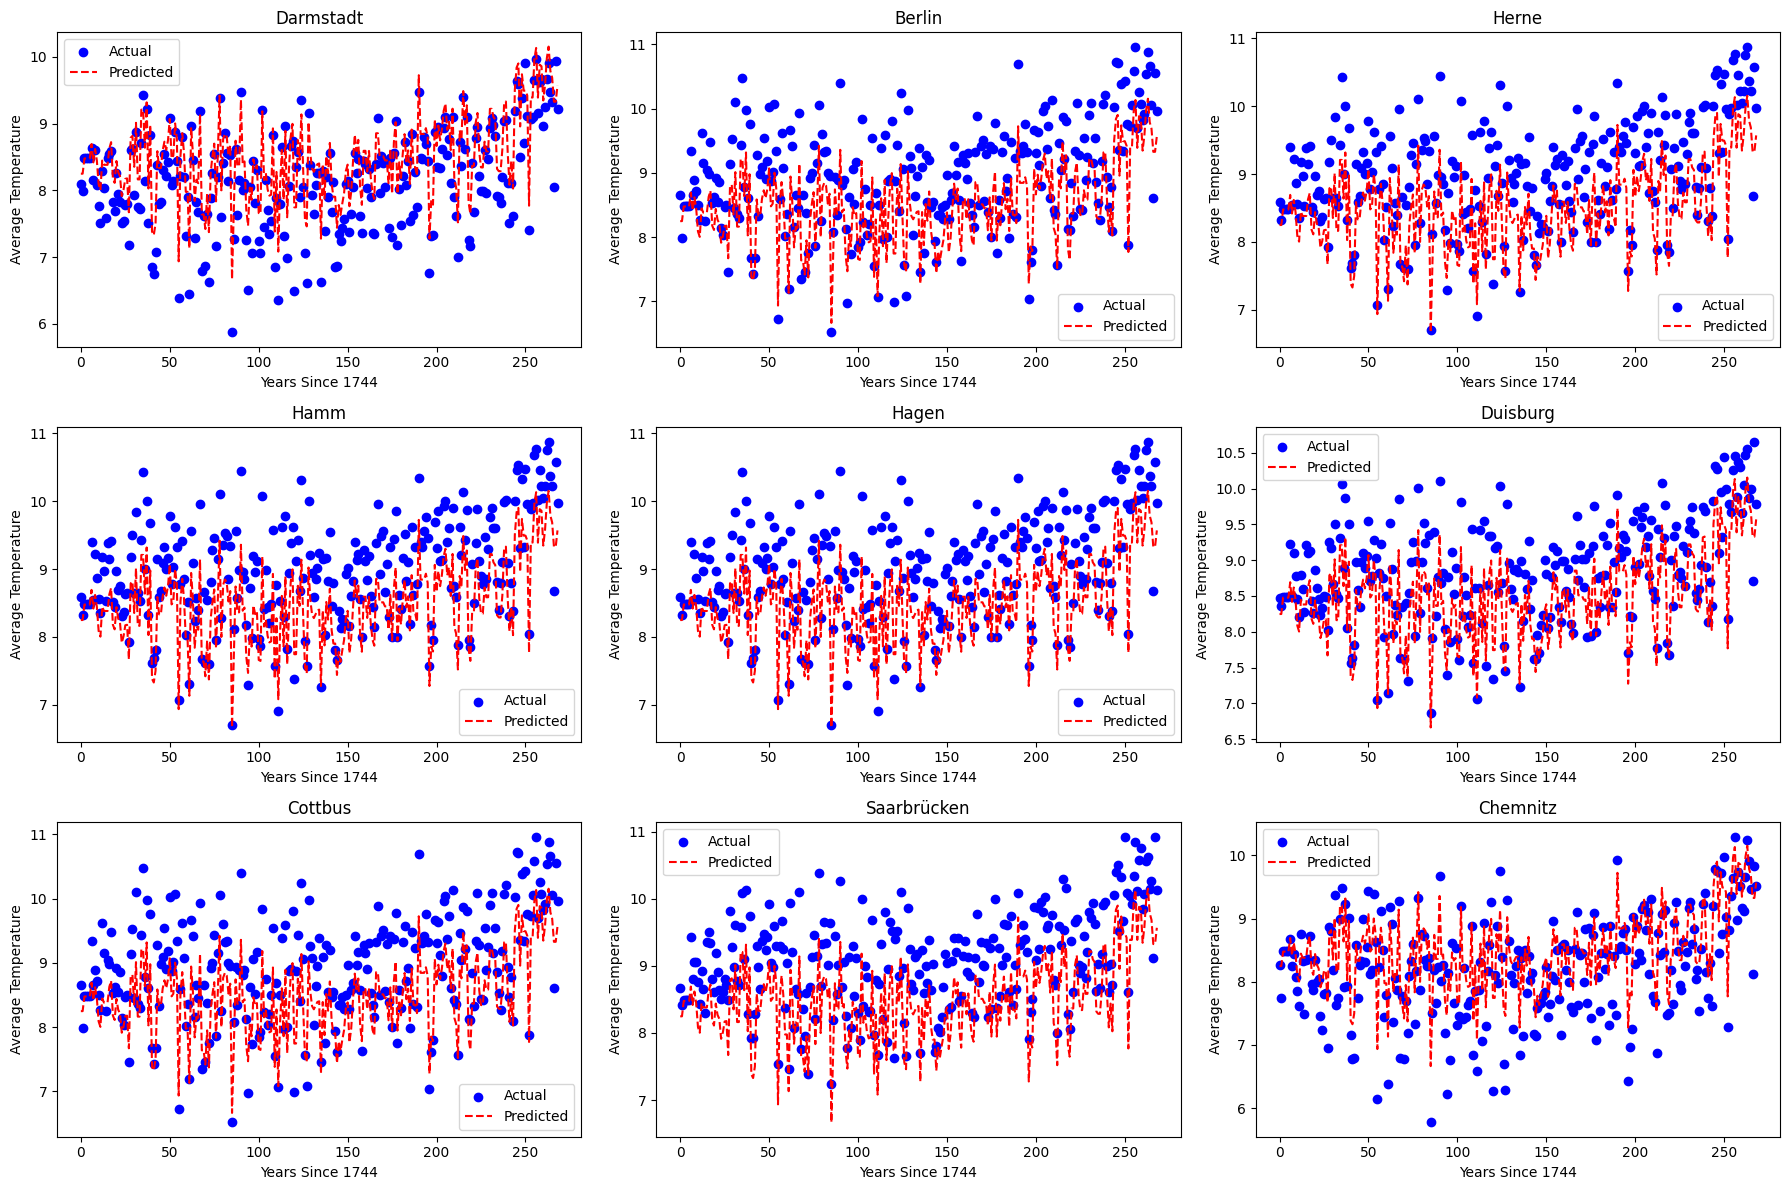

In [19]:
import random
# Select 9 random cities
random.seed(42)  # For reproducibility
selected_cities = random.sample(list(yearly_avg_temp['City'].unique()), 9)

# Create a 3x3 grid of subplots
plt.figure(figsize=(18, 12))
for i, city in enumerate(selected_cities, 1):
    plt.subplot(3, 3, i)
    
    # Filter data for the selected city
    city_data = yearly_avg_temp[yearly_avg_temp['City'] == city]
    X_city = city_data[['YearsSince1744']]
    y_city = city_data['AverageTemperature']
    y_city_pred = model.predict(X_city)
    
    # Plot actual vs predicted values
    plt.scatter(X_city, y_city, label='Actual', color='blue')
    plt.plot(X_city, y_city_pred, label='Predicted', color='red', linestyle='--')
    plt.xlabel('Years Since 1744')
    plt.ylabel('Average Temperature')
    plt.title(f'{city}')
    plt.legend()

plt.tight_layout()
plt.show()

In [20]:
# Make predictions on the test set
y_test_pred = model.predict(X_test)

# Calculate evaluation metrics for the test set
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the metrics
print("Test Set Metrics:")
print("Mean Absolute Error (MAE):", mae_test)
print("Mean Squared Error (MSE):", mse_test)
print("R-squared (R2):", r2_test)

Test Set Metrics:
Mean Absolute Error (MAE): 0.5242655151929648
Mean Squared Error (MSE): 0.682079570861802
R-squared (R2): 0.434445404888813


In [21]:
# Analyze the overall trend
if np.mean(y_test_pred) > np.mean(y_test):
    print("The model predicts a warming trend.")
else:
    print("The model predicts a cooling trend.")

The model predicts a warming trend.
